In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

import configparser
config = configparser.ConfigParser()
config.read('config.ini')

import wandb
wandb.login()

2.9.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


wandb: Currently logged in as: mhrnciar (nsiete-hrnciar-katkovcin). Use `wandb login --relogin` to force relogin


True

In [2]:
run = wandb.init(project="convolutional-nn", id="wider-conv-layers-3-image-generator")

In [3]:
EPOCHS = config['default'].getint('epochs')
IMAGE_SIZE = config['default'].getint('image_size')
BATCH_SIZE = config['default'].getint('batch_size')
SEED = config['default'].getint('seed')

wandb.config.update({'epochs': EPOCHS, 
                     'image_size': IMAGE_SIZE, 
                     'batch_size': BATCH_SIZE})

In [4]:
data_path = 'Data/original'

class_names = sorted(os.listdir(data_path))
num_classes = len(class_names)
print("Number of Classes:", num_classes)

class_sizes = []
for name in class_names:
    class_size = len(os.listdir(data_path + "/" + name))
    class_sizes.append(class_size)

print("Class Distribution:\n", dict(zip(class_names, class_sizes)))

Number of Classes: 10
Class Distribution:
 {'butterfly': 2112, 'cat': 1668, 'chicken': 3098, 'cow': 1866, 'dog': 4863, 'elephant': 1446, 'horse': 2623, 'sheep': 1820, 'spider': 4821, 'squirrel': 1862}


Exception in thread SystemMonitor:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/wandb/sdk/internal/system/system_monitor.py", line 118, in _start
    asset.start()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/wandb/sdk/internal/system/assets/cpu.py", line 166, in start
    self.metrics_monitor.start()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.8/site-packages/wandb/sdk/internal/system/assets/interfaces.py", line 168, in start
    logger.info(f"Started {self._process.name}")
AttributeError: 'NoneType' object has no attribute 'name'


In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'Data/original',
  validation_split=0.2,
  subset="training",
  seed=SEED,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  'Data/original',
  validation_split=0.2,
  subset="validation",
  seed=SEED,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-05 11:36:49.623178: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-05 11:36:49.623315: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


2023-04-05 11:36:50.742876: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


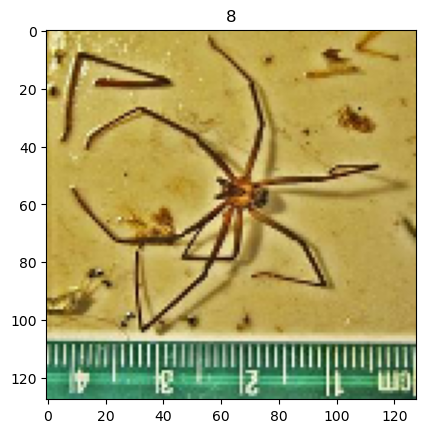

In [6]:
for images, labels in train_ds.take(1):
    plt.imshow(images[0].numpy().astype('uint8'))
    plt.title(labels[0].numpy())
    break

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
train_datagen =  tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
                  'Data/original',
                  target_size=(IMAGE_SIZE, IMAGE_SIZE),
                  batch_size=BATCH_SIZE,
                  shuffle=True,
                  subset='training',
                  class_mode='binary')

val_generator = train_datagen.flow_from_directory(
                  'Data/original',
                  target_size=(IMAGE_SIZE, IMAGE_SIZE),
                  batch_size=BATCH_SIZE,
                  shuffle=True,
                  subset='validation',
                  class_mode='binary')   

Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


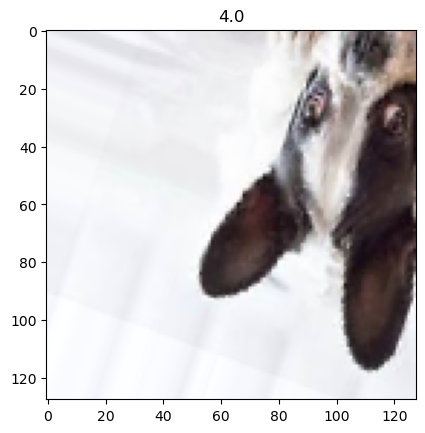

In [17]:
for images, labels in iter(train_generator):
    plt.imshow(images[0])
    plt.title(labels[0])
    break

In [18]:
class WandbCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        wandb.log(logs)

In [19]:
""" with tf.device('/cpu:0'):
  augment = tf.keras.Sequential([
      layers.Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.2)
  ]) """

model = tf.keras.Sequential([
    #augment,

    layers.Conv2D(32, 3, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10)
])

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

metrics = [
    tf.keras.metrics.SparseCategoricalAccuracy(),
    tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=True)
]

model.compile(loss=loss_fn, optimizer=optimizer, metrics=metrics)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 16, 16, 128)     

In [20]:
model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS, callbacks=[WandbCallback()])

Epoch 1/5


2023-04-05 11:38:28.068155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


655/655 [==============================] - ETA: 0s - loss: 1.9714 - sparse_categorical_accuracy: 0.3055 - sparse_categorical_crossentropy: 1.9714

2023-04-05 11:39:34.288038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


655/655 [==============================] - 82s 125ms/step - loss: 1.9714 - sparse_categorical_accuracy: 0.3055 - sparse_categorical_crossentropy: 1.9714 - val_loss: 1.8188 - val_sparse_categorical_accuracy: 0.3700 - val_sparse_categorical_crossentropy: 1.8188
Epoch 2/5
655/655 [==============================] - 81s 124ms/step - loss: 1.6982 - sparse_categorical_accuracy: 0.4106 - sparse_categorical_crossentropy: 1.6982 - val_loss: 1.6289 - val_sparse_categorical_accuracy: 0.4407 - val_sparse_categorical_crossentropy: 1.6289
Epoch 3/5
655/655 [==============================] - 81s 123ms/step - loss: 1.5681 - sparse_categorical_accuracy: 0.4590 - sparse_categorical_crossentropy: 1.5681 - val_loss: 1.5256 - val_sparse_categorical_accuracy: 0.4725 - val_sparse_categorical_crossentropy: 1.5256
Epoch 4/5
655/655 [==============================] - 81s 124ms/step - loss: 1.4545 - sparse_categorical_accuracy: 0.4951 - sparse_categorical_crossentropy: 1.4545 - val_loss: 1.4457 - val_sparse_categ

In [21]:
pd.DataFrame(model.history.history)

,loss,sparse_categorical_accuracy,sparse_categorical_crossentropy,val_loss,val_sparse_categorical_accuracy,val_sparse_categorical_crossentropy
0,1.971441,0.305485,1.971441,1.818768,0.370031,1.818768
1,1.698228,0.410608,1.698228,1.628910,0.440749,1.628910
2,1.568100,0.459016,1.568100,1.525581,0.472477,1.525581
3,1.454495,0.495059,1.454495,1.445741,0.506498,1.445741
4,1.384084,0.521507,1.384084,1.388619,0.528670,1.388619


In [24]:
model.evaluate(val_generator)

164/164 [==============================] - 16s 94ms/step - loss: 1.3997 - sparse_categorical_accuracy: 0.5140 - sparse_categorical_crossentropy: 1.3997


[1.3996630907058716, 0.5139526128768921, 1.3996630907058716]

In [23]:
tf.keras.models.save_model(model, "model/larger-conv-layers-3-image-generator.pth")
wandb.save('runs/pima_run_2023-04-05-larger-conv-layers-3-image-generator')
wandb.finish()

INFO:tensorflow:Assets written to: model/larger-conv-layers-3-image-generator.pth/assets


INFO:tensorflow:Assets written to: model/larger-conv-layers-3-image-generator.pth/assets


loss,█▅▃▂▁
sparse_categorical_accuracy,▁▄▆▇█
sparse_categorical_crossentropy,█▅▃▂▁
val_loss,█▅▃▂▁
val_sparse_categorical_accuracy,▁▄▆▇█
val_sparse_categorical_crossentropy,█▅▃▂▁
loss,1.38408
sparse_categorical_accuracy,0.52151
sparse_categorical_crossentropy,1.38408
val_loss,1.38862
val_sparse_categorical_accuracy,0.52867
